## Notebook Structure
In this Notebook I take a dive into Fully Connected Neural Network Structures. Testing the structure of Neural Networks and the their impact on binary classification.

Data: The data is the sequences of genes that are expressed at different points in Human Kidney samples. Using annotated data that matches up, Tertiary Lymphoid Structures were matched up.

Goal: The goal is to determin which genes are most prevalent when determining areas of tissue with Tertiary Lymphoid Structures.

1. Getting Started
1. Mount Google Drive
2. Download Data from Hugging Face and Save to Google Drive
3. Display Sample Data and Visualize It
4. Prepare Data for Training
5. Build the Models
6. Prepare the Data to be Loaded into the Model
7. Train the Model
8. Analyze Results



# 1. Getting Started

This section contains all of the necessary imports and downloads necessary to run the notebook bellow. They will be used through out the code as well to clearly show where they are being used.

## To run this notebook you will need...

Python Version 3.10 and acess to a GPU (I suggest using google Colab)

In [ ]:
# Data Handling and Manipulation
import os  # For file and directory operations
import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis

# Data Visualization
import matplotlib.pyplot as plt  # For creating plots and visualizations

# Data Preprocessing
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.model_selection import train_test_split  # For splitting data into train, test, and validation sets

# Machine Learning Metrics
from sklearn.metrics import (
    r2_score,           # To calculate R² score
    accuracy_score,     # To calculate accuracy
    precision_score,    # To calculate precision
    recall_score,       # To calculate recall
    f1_score,           # To calculate F1 score
    roc_auc_score,      # To calculate ROC-AUC score
    confusion_matrix,   # To create a confusion matrix
    ConfusionMatrixDisplay  # To display a confusion matrix
)

# PyTorch (Deep Learning Framework)
import torch  # Core PyTorch library
import torch.nn as nn  # For defining neural network layers
import torch.optim as optim  # For optimization algorithms
from torch.utils.data import DataLoader, TensorDataset, random_split  # For data loading and handling in PyTorch

# Google Colab (if applicable)
from google.colab import drive  # For mounting Google Drive in Colab

# Networking (optional, if fetching data online)
import requests  # For HTTP requests to fetch data
from io import StringIO  # For handling in-memory text streams

# 2. Mounting Google Drive

In [115]:
# Importing necessary libraries for mounting gogole drive
import torch
import pandas as pd
import os
from google.colab import drive
# If using on your own, change directory to own
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/Applied Deep Learning/Final_Project")
cwd = os.getcwd()
cwd


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/My Drive/Colab Notebooks/Applied Deep Learning/Final_Project'

# 3. Download Dataset from Hugging Face

In [ ]:
# The data is going to be temporarily saved, then merged and saved into google drive

In [3]:
import os
import pandas as pd
import numpy as np
import requests
from io import StringIO

# Base directory
base_dir = "/content/drive/My Drive/Colab Notebooks/Applied Deep Learning/Final_Project"

# Base URLs for data
data_url = "https://huggingface.co/datasets/jiawennnn/STimage-1K4M/resolve/main/Visium/"
anno_url = "https://huggingface.co/datasets/jiawennnn/STimage-1K4M/resolve/main/"

# URL endings for different data types
url_endings = {
    "gene_exp": "_count.csv",
    "annotation": "_anno.csv"
}

# Data name base and range
data_name = "GSE175540_GSM59240"
data_range = np.arange(30, 36, 1)

# Initialize a list to store merged data for all datasets
all_data = []

# Loop through each dataset and process
for i in data_range:
    dataset_name = f"{data_name}{i}"
    print(f"Processing dataset: {dataset_name}")

    try:
        # Download gene expression data
        gene_exp_url = f"{data_url}gene_exp/{dataset_name}{url_endings['gene_exp']}"
        gene_exp_response = requests.get(gene_exp_url)
        if gene_exp_response.status_code == 200:
            gene_exp_df = pd.read_csv(StringIO(gene_exp_response.text))
        else:
            print(f"Failed to download gene expression data for: {dataset_name} (Status: {gene_exp_response.status_code})")
            continue

        # Download annotation data
        annotation_url = f"{anno_url}annotation/{dataset_name}{url_endings['annotation']}"
        annotation_response = requests.get(annotation_url)
        if annotation_response.status_code == 200:
            annotation_df = pd.read_csv(StringIO(annotation_response.text))
        else:
            print(f"Failed to download annotation data for: {dataset_name} (Status: {annotation_response.status_code})")
            continue

        # Ensure the "Label" column exists in both datasets
        annotation_df.rename(columns={"Unnamed: 0": "Label", "V1": "Label"}, inplace=True, errors="ignore")
        gene_exp_df.rename(columns={"Unnamed: 0": "Label"}, inplace=True, errors="ignore")

        # Merge gene expression and annotation data on the "Label" column
        merged_df = pd.merge(gene_exp_df, annotation_df[['Label', 'TLS_2_cat']], on="Label", how="inner")

        # Append the merged data to the list
        all_data.append(merged_df)
        # Making sure the contents of data set is correct
        print(merged_df.head())

        print(f"Successfully processed dataset: {dataset_name}")
    except Exception as e:
        print(f"Error processing dataset {dataset_name}: {e}")

# Combine all merged datasets into a single DataFrame
if all_data:
    final_data = pd.concat(all_data, ignore_index=True)
    print(final_data.head())

    # Save the combined data to a CSV file
    output_path = os.path.join(base_dir, "combined_data.csv")
    final_data.to_csv(output_path, index=False)

    print(f"Combined data saved to: {output_path}")
    print(f"Final data has {final_data.shape[0]} rows and {final_data.shape[1]} columns.")
else:
    print("No datasets were successfully processed.")


Processing dataset: GSE175540_GSM5924030
                                     Label  SAMD11  NOC2L  KLHL17  PLEKHN1  \
0  GSE175540_GSM5924030_AAACAACGAATAGTTC-1     0.0    1.0     0.0      0.0   
1  GSE175540_GSM5924030_AAACAAGTATCTCCCA-1     0.0    2.0     1.0      0.0   
2  GSE175540_GSM5924030_AAACAATCTACTAGCA-1     0.0    0.0     0.0      0.0   
3  GSE175540_GSM5924030_AAACACCAATAACTGC-1     0.0    0.0     0.0      0.0   
4  GSE175540_GSM5924030_AAACAGAGCGACTCCT-1     0.0    0.0     0.0      0.0   

   PERM1  HES4  ISG15  AGRN  RNF223  ...  ZFY  PCDH11Y  AMELY  TBL1Y  TSPY1  \
0    0.0   0.0    0.0   3.0     0.0  ...  0.0      0.0    0.0    0.0    0.0   
1    0.0   0.0    7.0   1.0     0.0  ...  1.0      0.0    0.0    0.0    0.0   
2    0.0   2.0    2.0   1.0     0.0  ...  0.0      0.0    0.0    0.0    0.0   
3    0.0   0.0    0.0   2.0     0.0  ...  0.0      0.0    0.0    0.0    0.0   
4    0.0   0.0    0.0   0.0     0.0  ...  0.0      0.0    0.0    1.0    0.0   

   USP9Y  DDX3Y

## Visualize the Data working with

In [ ]:
# Visualizing the top 100 Genes by Count

   SAMD11  NOC2L  KLHL17  PLEKHN1  PERM1  HES4  ISG15  AGRN  RNF223  C1orf159  \
0     0.0    1.0     0.0      0.0    0.0   0.0    0.0   3.0     0.0       0.0   
1     0.0    2.0     1.0      0.0    0.0   0.0    7.0   1.0     0.0       0.0   
2     0.0    0.0     0.0      0.0    0.0   2.0    2.0   1.0     0.0       0.0   
3     0.0    0.0     0.0      0.0    0.0   0.0    0.0   2.0     0.0       0.0   
4     0.0    0.0     0.0      0.0    0.0   0.0    0.0   0.0     0.0       0.0   

   ...  SRY  ZFY  PCDH11Y  AMELY  TBL1Y  TSPY1  USP9Y  DDX3Y  TMSB4Y  KDM5D  
0  ...  0.0  0.0      0.0    0.0    0.0    0.0    0.0    0.0     0.0    1.0  
1  ...  0.0  1.0      0.0    0.0    0.0    0.0    1.0    3.0     0.0    4.0  
2  ...  0.0  0.0      0.0    0.0    0.0    0.0    0.0    0.0     0.0    1.0  
3  ...  0.0  0.0      0.0    0.0    0.0    0.0    0.0    0.0     0.0    0.0  
4  ...  0.0  0.0      0.0    0.0    1.0    0.0    0.0    0.0     0.0    1.0  

[5 rows x 17943 columns]


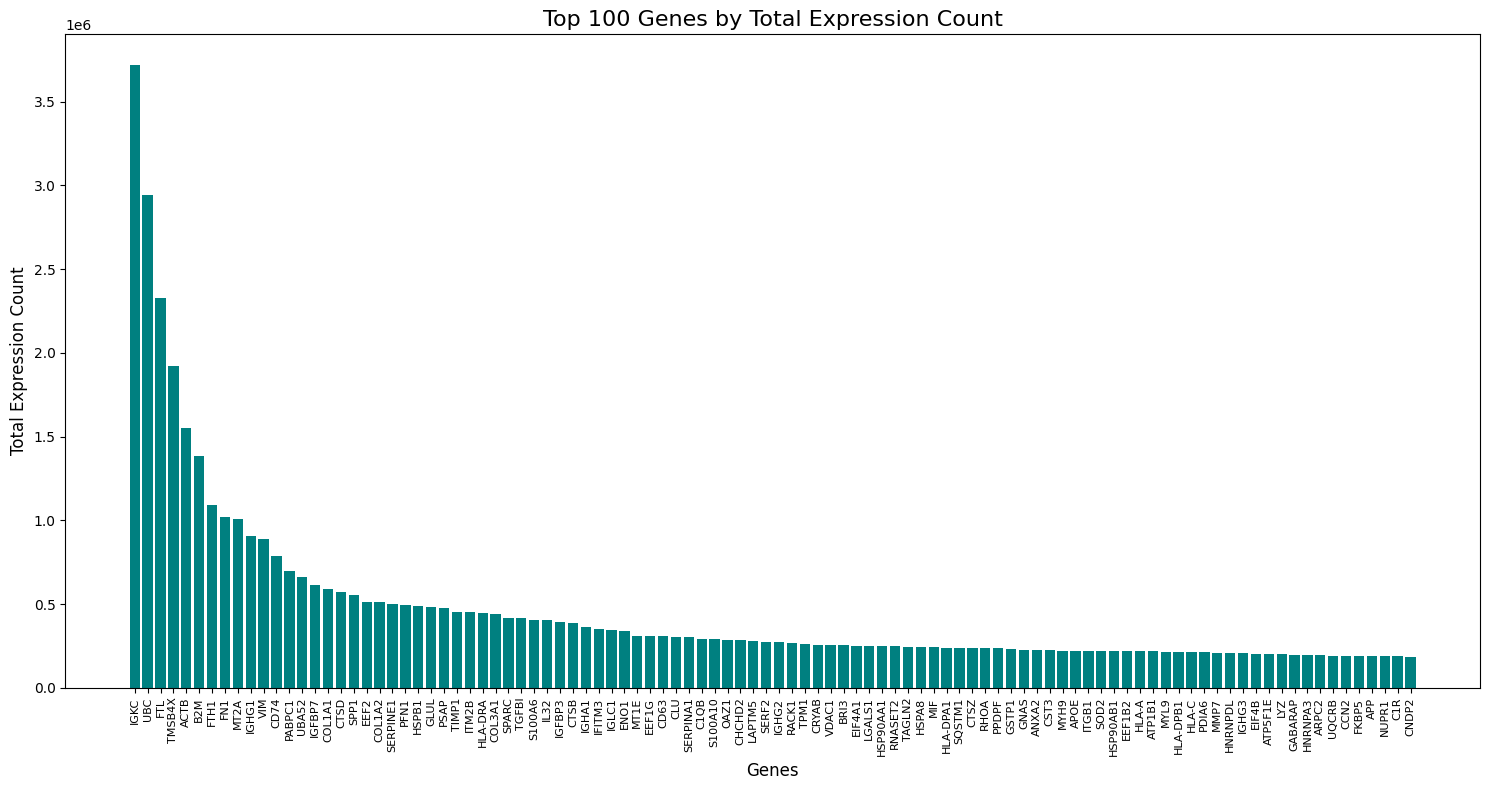

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Load the combined data
combined_data_path = "/content/drive/My Drive/Colab Notebooks/Applied Deep Learning/Final_Project/combined_data.csv"
data = pd.read_csv(combined_data_path)

# Exclude non-gene columns
gene_columns = data.loc[:, data.columns[1:-1]]
print(gene_columns.head())

# Calculate the total count for each gene
gene_totals = gene_columns.sum(axis=0)

# Sort by total count and select the top 100 genes
top_genes = gene_totals.sort_values(ascending=False).head(100)

# Plot the top 100 genes
# Create a bar chart with raw counts as bar heights and prevent scaling
plt.figure(figsize=(15, 8))

# Use numpy to create bar plot to avoid pandas scaling
x_pos = np.arange(len(top_genes)) # positions for bars
plt.bar(x_pos, top_genes.values, color="teal")

# Set x-axis labels to gene names
plt.xticks(x_pos, top_genes.index, rotation=90, fontsize=8)

plt.title("Top 100 Genes by Total Expression Count", fontsize=16)
plt.xlabel("Genes", fontsize=12)
plt.ylabel("Total Expression Count", fontsize=12)
plt.tight_layout()
graph_save_path = f"/content/drive/My Drive/Colab Notebooks/Applied Deep Learning/Final_Project/Results/Graphs/Data_Visualization.png"
plt.savefig(graph_save_path)
plt.show()


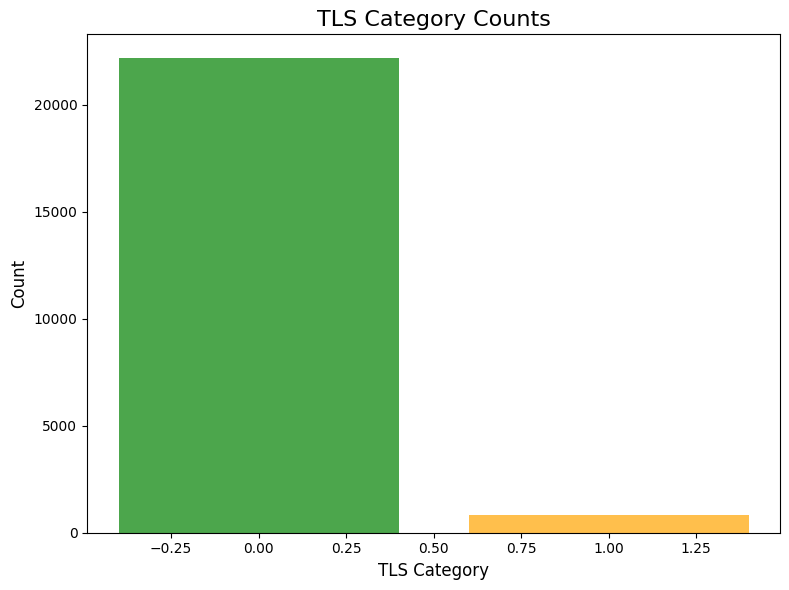

In [13]:
# Checking numbers of TLS + or -
# Separate data by TLS category
# Count the occurrences of each category
tls_counts = data['TLS_2_cat'].value_counts()

# Create a bar chart
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.bar(tls_counts.index, tls_counts.values, color=['green', 'orange'], alpha=0.7)

plt.title("TLS Category Counts", fontsize=16)
plt.xlabel("TLS Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=10)  # Adjust font size if needed
plt.tight_layout()
graph_save_path = f"/content/drive/My Drive/Colab Notebooks/Applied Deep Learning/Final_Project/Results/Graphs/TLS_Counts.png"
plt.savefig(graph_save_path)
plt.show()



# 4. Display Sample Data and Visualize It

Data is now merged together with each spacial indicator being its own data point. There is 23,016 data points, and 17943 possible genes that will be used as predictors for TLS + or TLS -




In [8]:
import pandas as pd

# Load the combined dataset
file_path = "/content/drive/My Drive/Colab Notebooks/Applied Deep Learning/Final_Project/combined_data.csv"
data = pd.read_csv(file_path)

# Exclude non-gene columns
gene_columns = data.loc[:, data.columns[1:-1]]
print(gene_columns.head())

# Display basic information about the data
print("Data shape:", data.shape)
print("Column names:", data.columns)
print(data.head())


   SAMD11  NOC2L  KLHL17  PLEKHN1  PERM1  HES4  ISG15  AGRN  RNF223  C1orf159  \
0     0.0    1.0     0.0      0.0    0.0   0.0    0.0   3.0     0.0       0.0   
1     0.0    2.0     1.0      0.0    0.0   0.0    7.0   1.0     0.0       0.0   
2     0.0    0.0     0.0      0.0    0.0   2.0    2.0   1.0     0.0       0.0   
3     0.0    0.0     0.0      0.0    0.0   0.0    0.0   2.0     0.0       0.0   
4     0.0    0.0     0.0      0.0    0.0   0.0    0.0   0.0     0.0       0.0   

   ...  SRY  ZFY  PCDH11Y  AMELY  TBL1Y  TSPY1  USP9Y  DDX3Y  TMSB4Y  KDM5D  
0  ...  0.0  0.0      0.0    0.0    0.0    0.0    0.0    0.0     0.0    1.0  
1  ...  0.0  1.0      0.0    0.0    0.0    0.0    1.0    3.0     0.0    4.0  
2  ...  0.0  0.0      0.0    0.0    0.0    0.0    0.0    0.0     0.0    1.0  
3  ...  0.0  0.0      0.0    0.0    0.0    0.0    0.0    0.0     0.0    0.0  
4  ...  0.0  0.0      0.0    0.0    1.0    0.0    0.0    0.0     0.0    1.0  

[5 rows x 17943 columns]
Data shape: (23017,

In [9]:
# Map TLS_2_cat to binary, TLS -> 1, No_TLS -> 0
# Convert TLS_Cat to binary values
data["TLS_2_cat"] = data["TLS_2_cat"].map({"TLS": 1, "NO_TLS": 0})

# Remove any NaN columns from the data. Clean the data.
data_cleaned = data.dropna(subset=['TLS_2_cat'])  # Remove NaN from all cols or subset=['TLS_2_cat'] to specific col

print(data_cleaned[['TLS_2_cat']].head())

# Confirm the conversion
print(data_cleaned["TLS_2_cat"].value_counts())


   TLS_2_cat
0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
TLS_2_cat
0.0    22176
1.0      817
Name: count, dtype: int64


# 5. Getting Data Ready For Training

Normalize Data: The data needs to be normalized so that features with larger values fo not dominate the model's learning process which could result in biased results.

Split Data into Train, Test, Validation Sets: Ratio of 70/15/15. All samples will be randomized and then split into their respective sets.

Clean Data: Remove any NaN values from data set.

In [10]:
import numpy as np
# Extract Features and Labels
# Features (X) are all of the genes that are or are not expressed for each sample
X = data_cleaned[gene_columns.columns].values
# Labels (y) are the binary results of TLS expression, 0 = no_TLS, 1 = TLS
y = data_cleaned["TLS_2_cat"].values

# Check for and handle NaN values in 'y' before splitting
print(f"Number of NaN values in 'y' before handling: {np.isnan(y).sum()}")

# Visualize the shape of the features and lables
print("Feature matrix shape:", X.shape)
print("Labels shape:", y.shape)

Number of NaN values in 'y' before handling: 0
Feature matrix shape: (22993, 17943)
Labels shape: (22993,)


In [11]:
# Normalize the Gene Expession Data
from sklearn.preprocessing import StandardScaler

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Confirm the normalization
print("Normalized feature matrix shape:", X_normalized.shape)


Normalized feature matrix shape: (22993, 17943)


Split the Data into Train, Test, and Validation and Display the Splits

Training set size: 16095
Validation set size: 3449
Test set size: 3449


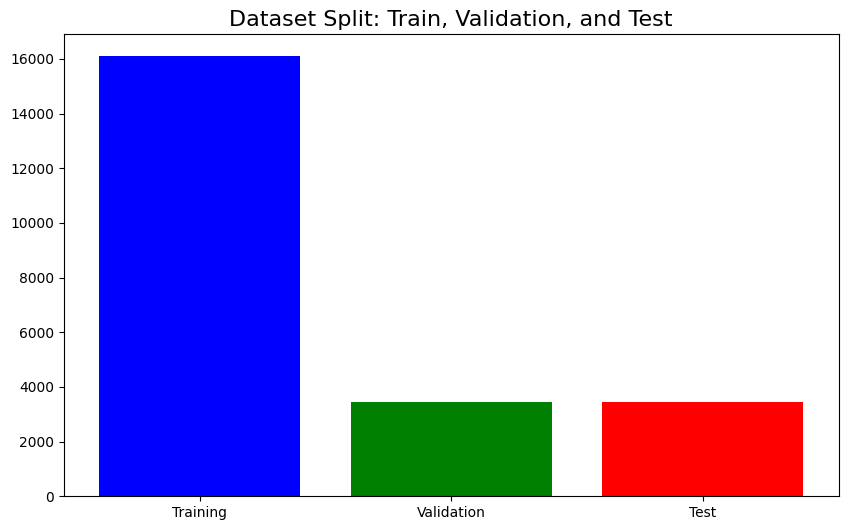

In [14]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Split the data into training and testing sets (70/30 split)
X_train, X_temp, y_train, y_temp = train_test_split(X_normalized, y, test_size=0.3, random_state=42, stratify=y)

# Further split the temporary set into validation and test sets (50/50 split)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Display the split sizes
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])
# Plot results of split and save
plt.figure(figsize=(10, 6))
plt.bar(['Training', 'Validation', 'Test'], [X_train.shape[0], X_val.shape[0], X_test.shape[0]], color=['blue', 'green', 'red'])
plt.title('Dataset Split: Train, Validation, and Test', fontsize=16)
graph_save_path = f"/content/drive/My Drive/Colab Notebooks/Applied Deep Learning/Final_Project/Results/Graphs/Data_Split_Visualization.png"
plt.savefig(graph_save_path)
plt.show()

# 6. Build the Models

Creating a Convolutional Neaural Network for TLS Expression Based on Gene Expression

In [105]:
# Import Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Define input_dim, the number of possible genes

# Define the FCNN Class Called TLS_Identifier_CNN
# This First FCNN is Simple, 4 total layers, 2 hidden layers, with ReLU, Drop out and Sigmoid Binary Classification.
# Number of Hidden Layers:
#     Too few layers: The model may be unable to capture complex patterns.
#     Too many layers: The model may overfit or become computationally expensive.

# Test combinations of layers and neurons. For example:

# Layers: [1, 2, 3]
# Neurons: [64, 128, 256]
# Example combinations:

# 1 layer with 64 neurons.
# 2 layers with 128 → 64 neurons.
# 3 layers with 256 → 128 → 64 neurons.
class Simple_FCNN(nn.Module):
    def __init__(self, input_size):
      super(Simple_FCNN, self).__init__()

      # Define Input Layer which will pass information to hidden layers. Going from n-number of Genes to 128 neurons
      self.fc1 = nn.Linear(input_dim, 128)  # Fully connected layer
      self.relu = nn.ReLU()                 # ReLU (Rectified Linear Unit) activation for non-linearity

      # Hidden Layer 1 to Hidden Layer 2 (64 neurons)
      # Creating drop out layer to hopefully avoid overfitting by randomly dropping neurons throughout training
      self.fc2 = nn.Linear(128, 64)        # Fully connected layer
      self.dropout = nn.Dropout(0.3)       # Dropout for regularization

      # Hidden Layer 2 to Output Layer (1 neuron)
      # Applying signmoid layer to output for final binary classification, TLS(1), or NO_TLS(0)
      self.fc3 = nn.Linear(64, 1)           # Fully connected layer (1 neuron for binary classification)
      self.sigmoid = nn.Sigmoid()           # Sigmoid activation for binary classification

    def forward(self, x):
      # Define the forward pass
      x = self.relu(self.fc1(x))            # Apply ReLU after first layer
      x = self.dropout(x)                   # Apply Dropout
      x = self.relu(self.fc2(x))            # Apply ReLU after second layer
      x = self.dropout(x)                   # Apply Dropout again
      x = self.sigmoid(self.fc3(x))         # Apply Sigmoid for final probability output
      return x

# Creating another FCNN called Deep_FCNN which has 4 layers and increased amounts of neurons
# This model will be more computationally expensive
class Deep_FCNN(nn.Module):
    def __init__(self, input_dim):
      super(Deep_FCNN, self).__init__()
      self.fc1 = torch.nn.Linear(input_dim, 256)  # Increase neurons
      self.fc2 = torch.nn.Linear(256, 128)
      self.fc3 = torch.nn.Linear(128, 64)
      self.fc4 = torch.nn.Linear(64, 1)
      self.relu = torch.nn.ReLU()
      self.sigmoid = torch.nn.Sigmoid()
      self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, x):
      x = self.relu(self.fc1(x))
      x = self.dropout(x)
      x = self.relu(self.fc2(x))
      x = self.dropout(x)
      x = self.relu(self.fc3(x))
      x = self.dropout(x)
      x = self.sigmoid(self.fc4(x))
      return x


# Creating another FCNN called BatchNorm_FCNN which is similar to deep FCNN, but adds a batch normalization layer after each hidden layer
# Normalizes activations during training, which can accelerate convergence
# Reduces internal covariate shift, improving generalization
class BatchNorm_FCNN(torch.nn.Module):
    def __init__(self, input_dim):
      super(BatchNorm_FCNN, self).__init__()
      self.fc1 = torch.nn.Linear(input_dim, 256)
      self.bn1 = torch.nn.BatchNorm1d(256)  # Batch normalization, after head hidden layer
      self.fc2 = torch.nn.Linear(256, 128)
      self.bn2 = torch.nn.BatchNorm1d(128)
      self.fc3 = torch.nn.Linear(128, 64)
      self.bn3 = torch.nn.BatchNorm1d(64)
      self.fc4 = torch.nn.Linear(64, 1)
      self.relu = torch.nn.ReLU()
      self.sigmoid = torch.nn.Sigmoid()
      self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, x):
      x = self.relu(self.bn1(self.fc1(x)))  # Batch normalization after fc1, and again after each layer
      x = self.dropout(x)
      x = self.relu(self.bn2(self.fc2(x)))
      x = self.dropout(x)
      x = self.relu(self.bn3(self.fc3(x)))
      x = self.dropout(x)
      x = self.sigmoid(self.fc4(x))
      return x

# Creating another FCNN called Residual_FCNN
# Adding residual connections to the model, allowing the network to learn idenity mappig
# This may help mitigate vanishing gradient in the deeper network
# Allowing the model to retain learned patterns from earlier layers
class Residual_FCNN(torch.nn.Module):
    def __init__(self, input_dim):
      super(Residual_FCNN, self).__init__()
      self.fc1 = torch.nn.Linear(input_dim, 256)
      self.fc2 = torch.nn.Linear(256, 128)
      self.fc3 = torch.nn.Linear(128, 64)
      self.fc4 = torch.nn.Linear(64, 1)
      self.relu = torch.nn.ReLU()
      self.sigmoid = torch.nn.Sigmoid()
      self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, x):
      # Applying a linear transformation to the input to match the dimensions of fc2 output
      # This creates a new "identity" that has the correct dimensions
      identity = self.fc1(x)
      identity = self.relu(identity) # Applying activation to match post-activation output
      identity = self.dropout(identity) # Applying regularization, and matching fc2 input dimension
      identity = self.fc2(identity)
      # Performing the rest of the forward pass as before
      x = self.relu(self.fc1(x))
      x = self.dropout(x)
      # Adding the modified "identity" here which now has the correct dimensions
      x = self.relu(self.fc2(x) + identity)  # Residual connection
      x = self.dropout(x)
      x = self.relu(self.fc3(x))
      x = self.dropout(x)
      x = self.sigmoid(self.fc4(x))
      return x

# 7. Prepare the Data to be Loaded into the Model

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np


# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Unsqueeze to make it 2D

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Initailizing the Model

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim

# Model initialization
input_dim = X_train.shape[1]  # Number of genes (input features)
model = Simple_FCNN(input_dim)  # Change each time you want to use a new model

# Get the model's class name as a string
model_name = model.__class__.__name__

# Loss function
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification


# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

Setting Up Foulders to Save Results

In [108]:
# Defining a Save path
save_path = "/content/drive/My Drive/Colab Notebooks/Applied Deep Learning/Final_Project/"

# Define the folders you want to create
folders = {
    "results": os.path.join(save_path, "Results"),
    "graphs": os.path.join(save_path, "Results/Graphs"),
    "models": os.path.join(save_path, "Results/Best_Models"),
}

# Create the folders
for folder_name, folder_path in folders.items():
    os.makedirs(folder_path, exist_ok=True)
    print(f"Folder '{folder_name}' created at: {folder_path}")

Folder 'results' created at: /content/drive/My Drive/Colab Notebooks/Applied Deep Learning/Final_Project/Results
Folder 'graphs' created at: /content/drive/My Drive/Colab Notebooks/Applied Deep Learning/Final_Project/Results/Graphs
Folder 'models' created at: /content/drive/My Drive/Colab Notebooks/Applied Deep Learning/Final_Project/Results/Best_Models


# 8. Train the Model

In [109]:
from sklearn.metrics import r2_score, accuracy_score

# Initialize lists to store metrics
train_losses, val_losses = [], []
train_r2_scores, val_r2_scores = [], []
train_accuracies, val_accuracies = [], []

epochs = 25
best_val_loss = float('inf') # Initialize best_val_loss to infinity so first epoch will replace it

# Training Loop
for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_preds, train_true = [], []

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Clear previous gradients
        y_pred = model(X_batch)  # Forward pass
        loss = criterion(y_pred, y_batch)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
        train_loss += loss.item()  # Accumulate loss

        # Store predictions and true labels for metrics
        train_preds.extend(y_pred.detach().numpy())
        train_true.extend(y_batch.detach().numpy())

    # Calculate training metrics
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2_scores.append(r2_score(train_true, train_preds))
    train_accuracies.append(accuracy_score(train_true, (np.array(train_preds) > 0.5).astype(int)))

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_preds, val_true = [], []

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
            val_preds.extend(y_pred.detach().numpy())
            val_true.extend(y_batch.detach().numpy())
    # Determining the "Best" model based on validation loss,
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_path = os.path.join(save_path, "Results/Best_Models", f"best_model_{model_name}.pth")


    # Calculate validation metrics
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_r2_scores.append(r2_score(val_true, val_preds))
    val_accuracies.append(accuracy_score(val_true, (np.array(val_preds) > 0.5).astype(int)))

    # Print metrics for the epoch
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Train R2: {train_r2_scores[-1]:.4f}, Val R2: {val_r2_scores[-1]:.4f}")
    print(f"Train Accuracy: {train_accuracies[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")
# Save " Best" model
best_model_path = os.path.join(save_path, "Results/Best_Models", f"best_model_{model_name}.pth")
torch.save(model.state_dict(), best_model_path)
print(f"Saved best model for {model_name} at Epoch {epoch+1}")

Epoch 1/25
Train Loss: 0.1432, Val Loss: 0.0944
Train R2: 0.1007, Val R2: 0.2965
Train Accuracy: 0.9655, Val Accuracy: 0.9684
Epoch 2/25
Train Loss: 0.0710, Val Loss: 0.0822
Train R2: 0.4730, Val R2: 0.3477
Train Accuracy: 0.9771, Val Accuracy: 0.9698
Epoch 3/25
Train Loss: 0.0384, Val Loss: 0.1288
Train R2: 0.7412, Val R2: 0.3022
Train Accuracy: 0.9898, Val Accuracy: 0.9716
Epoch 4/25
Train Loss: 0.0280, Val Loss: 0.1185
Train R2: 0.8189, Val R2: 0.3089
Train Accuracy: 0.9927, Val Accuracy: 0.9733
Epoch 5/25
Train Loss: 0.0158, Val Loss: 0.1685
Train R2: 0.8883, Val R2: 0.2739
Train Accuracy: 0.9953, Val Accuracy: 0.9722
Epoch 6/25
Train Loss: 0.0258, Val Loss: 0.1767
Train R2: 0.8454, Val R2: 0.2314
Train Accuracy: 0.9934, Val Accuracy: 0.9698
Epoch 7/25
Train Loss: 0.0170, Val Loss: 0.1893
Train R2: 0.8924, Val R2: 0.2483
Train Accuracy: 0.9957, Val Accuracy: 0.9701
Epoch 8/25
Train Loss: 0.0124, Val Loss: 0.2363
Train R2: 0.9225, Val R2: 0.1785
Train Accuracy: 0.9966, Val Accuracy:

# 9. Analyze Results

Saving Results For Each Model Created

Using Saliency for Model Interpetability. Showing the results for one TLS+ and one TLS-

TLS+ sample index: 25
TLS- sample index: 0


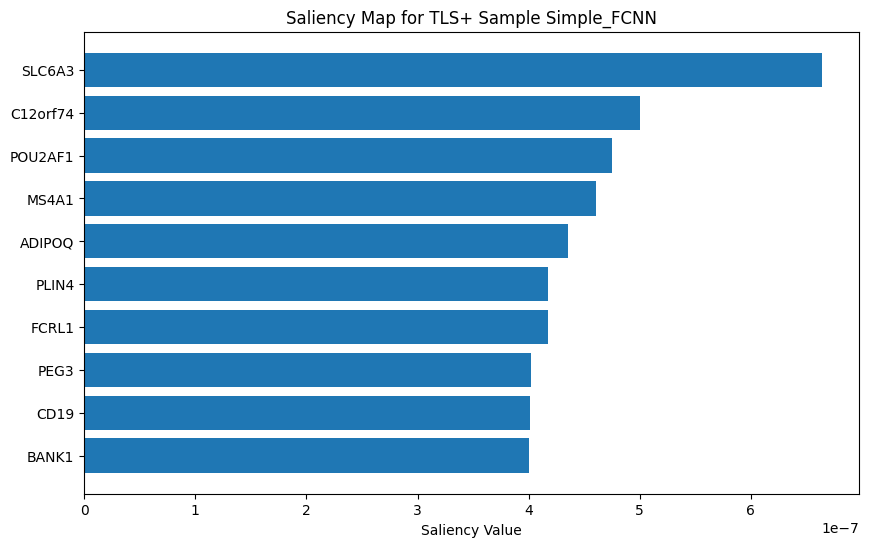

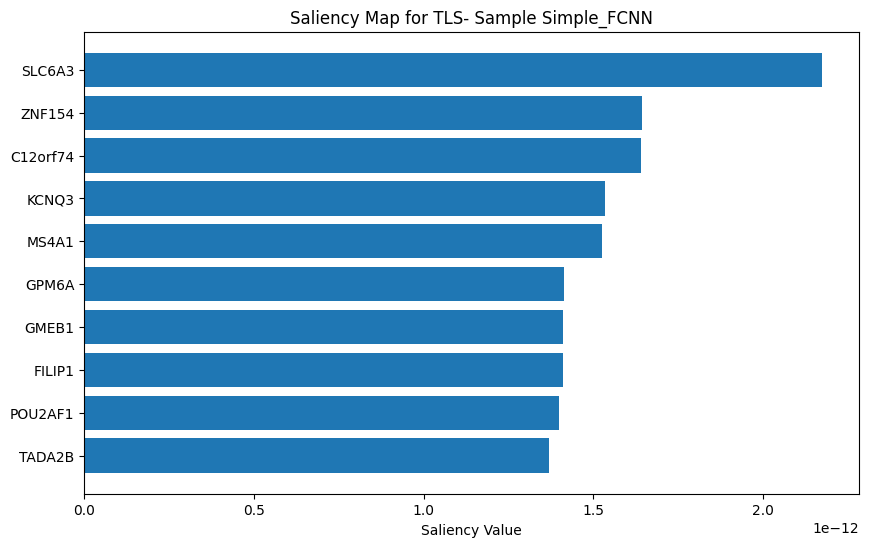

In [110]:

# Identify indices of TLS+ and TLS- samples in the test set
tls_plus_idx = np.where(y_test == 1)[0][0]  # First TLS+ sample
tls_minus_idx = np.where(y_test == 0)[0][0]  # First TLS- sample

print(f"TLS+ sample index: {tls_plus_idx}")
print(f"TLS- sample index: {tls_minus_idx}")

# Ensure the model is in evaluation mode
model.eval()

# Convert test set to a PyTorch tensor
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, requires_grad=True)

# Select TLS+ and TLS- samples
tls_plus_sample = X_test_tensor[tls_plus_idx].unsqueeze(0)  # Add batch dimension
tls_minus_sample = X_test_tensor[tls_minus_idx].unsqueeze(0)

# Forward pass for TLS+ sample
tls_plus_output = model(tls_plus_sample)
tls_plus_output.backward()  # Compute gradients for TLS+
tls_plus_saliency = X_test_tensor.grad[tls_plus_idx].abs().detach().numpy()  # Absolute gradients

# Forward pass for TLS- sample
X_test_tensor.grad.zero_()  # Clear gradients from the previous computation
tls_minus_output = model(tls_minus_sample)
tls_minus_output.backward()  # Compute gradients for TLS-
tls_minus_saliency = X_test_tensor.grad[tls_minus_idx].abs().detach().numpy()

# Visualize Saliency Maps
def plot_saliency(saliency, title, gene_columns):
    top_genes = np.argsort(saliency)[::-1][:10]  # Top 10 most influential genes
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(gene_columns)[top_genes], saliency[top_genes])
    plt.xlabel("Saliency Value")
    plt.title(title)
    plt.gca().invert_yaxis()
    graph_save_path = os.path.join(folders["graphs"], f"{title}_{model_name}.png")
    plt.savefig(graph_save_path)
    plt.show()

# Plot saliency maps
plot_saliency(tls_plus_saliency, f"Saliency Map for TLS+ Sample {model_name}", gene_columns.columns)
plot_saliency(tls_minus_saliency, f"Saliency Map for TLS- Sample {model_name}", gene_columns.columns)

Plotting Loss, R_Score, and Accuracy to Visualize Training Process

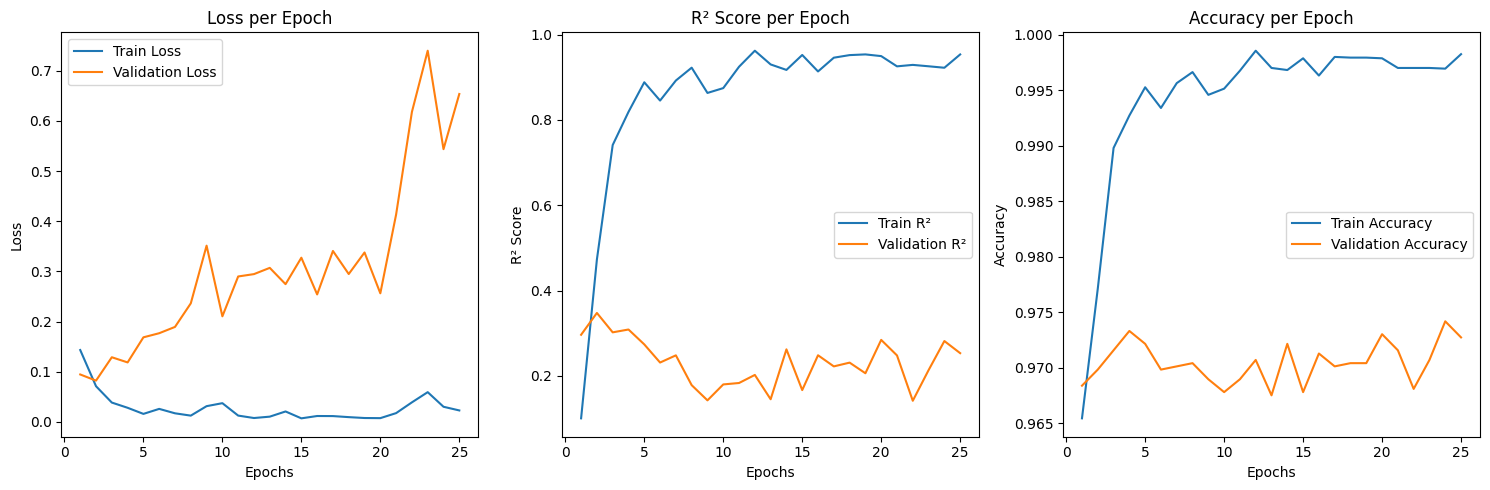

In [111]:
import matplotlib.pyplot as plt

# Create a figure for side-by-side plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot Losses
axs[0].plot(range(1, epochs + 1), train_losses, label='Train Loss')
axs[0].plot(range(1, epochs + 1), val_losses, label='Validation Loss')
axs[0].set_title('Loss per Epoch')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot R2 Scores
axs[1].plot(range(1, epochs + 1), train_r2_scores, label='Train R²')
axs[1].plot(range(1, epochs + 1), val_r2_scores, label='Validation R²')
axs[1].set_title('R² Score per Epoch')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('R² Score')
axs[1].legend()

# Plot Accuracies
axs[2].plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
axs[2].plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
axs[2].set_title('Accuracy per Epoch')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Accuracy')
axs[2].legend()

# Adjust layout, save image and show
plt.tight_layout()
graph_save_path = os.path.join(folders["graphs"], f"Result_Curves_{model_name}.png")
plt.savefig(graph_save_path)
plt.show()

Load the Best Model and Evalutate

In [112]:
# Load the best model
model.load_state_dict(torch.load(best_model_path))
# Save best model
model_save_path = os.path.join(folders["models"], f"best_model_{model_name}.pth")
torch.save(model.state_dict(), model_save_path)

# Evaluate on the test set
model.eval()
test_loss = 0.0
y_preds = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        test_loss += loss.item()
        y_preds.append(y_pred)
        y_true.append(y_batch)

# Convert predictions and true labels to numpy arrays
y_preds = torch.cat(y_preds).numpy()
y_true = torch.cat(y_true).numpy()

# Binarize predictions (threshold = 0.5)
y_preds_binary = (y_preds > 0.5).astype(int)

print(f"Test Loss: {test_loss / len(test_loader):.4f}")


<ipython-input-112-e416438110fe>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Test Loss: 0.7960


Evaluate Model Performance

Test Accuracy: 0.9675
Test Precision: 0.5833
Test Recall: 0.2869
Test F1 Score: 0.3846
Test ROC-AUC: 0.8534


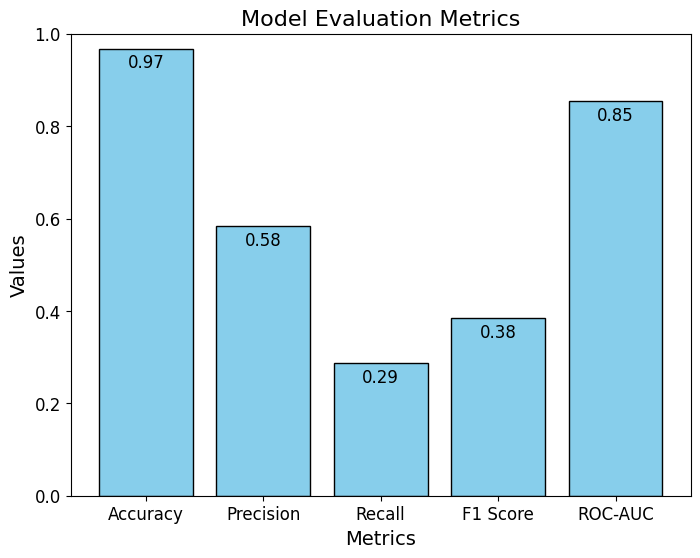

In [113]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calculate metrics
accuracy = accuracy_score(y_true, y_preds_binary)
precision = precision_score(y_true, y_preds_binary)
recall = recall_score(y_true, y_preds_binary)
f1 = f1_score(y_true, y_preds_binary)
roc_auc = roc_auc_score(y_true, y_preds)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test ROC-AUC: {roc_auc:.4f}")


metrics = {
    "Accuracy": accuracy_score(y_true, y_preds_binary),
    "Precision": precision_score(y_true, y_preds_binary),
    "Recall": recall_score(y_true, y_preds_binary),
    "F1 Score": f1_score(y_true, y_preds_binary),
    "ROC-AUC": roc_auc_score(y_true, y_preds)
}

# Plotting the metrics
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics.keys(), metrics.values(), color="skyblue", edgecolor="black")

# Add value labels on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05,
             f"{bar.get_height():.2f}", ha='center', va='bottom', fontsize=12, color="black")

plt.xlabel("Metrics", fontsize=14)
plt.ylabel("Values", fontsize=14)
plt.title("Model Evaluation Metrics", fontsize=16)
plt.ylim(0, 1.0)  # Metrics are on a scale of 0 to 1
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
graph_save_path = os.path.join(folders["graphs"], f"{model_name}_Evaluation_Metrics.png")
plt.savefig(graph_save_path)
plt.show()

Visualizing the Results with a Confusion Matrix

<Figure size 800x600 with 0 Axes>

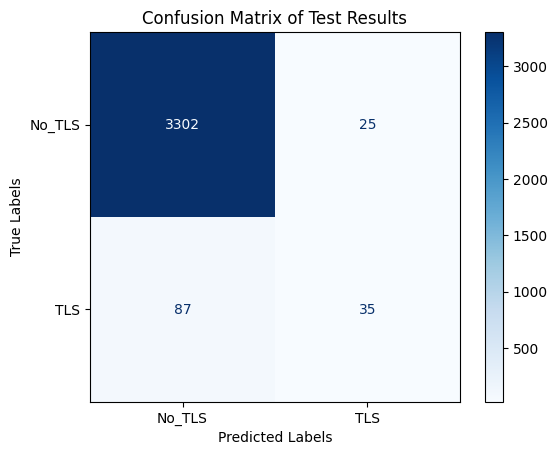

In [114]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.figure(figsize=(8, 6))
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_preds_binary)

# Display the confusion matrix using sklearn's ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["No_TLS", "TLS"])
disp.plot(cmap='Blues', values_format='d')

# Add title and labels
plt.title("Confusion Matrix of Test Results")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
# Save figure then show
graph_save_path = os.path.join(folders["graphs"], f"Confusion_Matrix_{model_name}.png")
plt.savefig(graph_save_path)
plt.show()